## import문

In [2]:
# sys
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import time
import pickle

import numpy as np
import pandas as pd# sys
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import time
import pickle

import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트
from matplotlib import rc # 폰트
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tensorflow
import tensorflow as tf
## keras
from tensorflow.keras import layers, models, metrics, callbacks
## for modeling
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, GRU, Attention, Concatenate, Flatten, Normalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
## preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
## utils
from tensorflow.keras.utils import plot_model
## saving
from tensorflow.keras.saving import save_model

# notification
# from knockknock import desktop_sender
from tqdm.notebook import tqdm
tqdm.pandas()

# customization
## tqdm (with ANSI escape codes)
dark_green = "\033[1;32;40m"
bar_format = f"{dark_green}{{l_bar}}{{bar:50}} [{{elapsed}}]{{r_bar}}"

## font
# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = True


# visualize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트
from matplotlib import rc # 폰트
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tensorflow
import tensorflow as tf
## keras
from tensorflow.keras import layers, models, metrics, callbacks
## for modeling
from tensorflow.keras.layers import Input, Embedding, Concatenate, Normalization
from tensorflow.keras.layers import Dense, LSTM, GRU, Attention
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
## preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
## utils
from tensorflow.keras.utils import plot_model
## saving
from tensorflow.keras.saving import save_model
# notification
# from knockknock import desktop_sender
from tqdm.notebook import tqdm
tqdm.pandas()

# customization

## font
# plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = True


## Before Configuration

In [3]:
f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/raw data/1_구어체(1).pickle', 'rb')
corpus_1 = pickle.load(f)
f.close()

f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/raw data/한영 병렬 말뭉치1.pickle', 'rb')
corpus_2 = pickle.load(f)
f.close()

f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/raw data/한영 병렬 말뭉치2.pickle', 'rb')
corpus_3 = pickle.load(f)
f.close()

corpus_1= corpus_1[['원문', '번역문']]

In [4]:
corpus_concat = pd.concat([corpus_1, corpus_2, corpus_3])
corpus_concat

,원문,번역문
0,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,씨티은행에서 일하세요?,Do you work at a City bank?
2,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...
99995,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


In [6]:
concat_ko = corpus_concat['원문'].to_list()
concat_en = corpus_concat['번역문'].to_list()

In [7]:
f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/3000000/ko_corpus.pkl', 'wb')
pickle.dump(concat_ko, f)
f.close()

f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/3000000/en_corpus.pkl', 'wb')
pickle.dump(concat_en, f)
f.close()

In [8]:
# 원문에서도 영어가 껴있고, 어차피 조사만 따로 버릴 것도 아니기에 한국어, 영어 동일하게 전처리 하겠습니다.
def preprocess_sentence(sent):
    sent = re.sub(r"([?.!,¿])", r" \1", sent) # 구두점 앞 공백 추가
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent) # 다수의 공백을 하나의 공백으로 치환
    
    return sent


# 학습 데이터, 타겟 데이터 생성 함수
def load_preprocessed_data(ko_corpus, en_corpus, debug=False):
    encoder_input, decoder_input, decoder_target = [], [], []
    # encoder_input: encoder layer에 들어갈 학습 데이터
    # decoder_input: decoder layer에 들어갈 학습 데이터(teacher forcing용)
    # decoder_target: decoder layer에서 나온 결과랑 비교할 타겟 데이터
    
    for i, (src_line, tar_line) in tqdm(enumerate(zip(ko_corpus, en_corpus))):

        # source 데이터 (scr_lin) 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]
        
        # target 데이터 (tar_line) 전처리
        tar_line = preprocess_sentence(tar_line) 
        tar_line_in = [w for w in ("<sos> " + tar_line).split()] # target for teacher forcing
        tar_line_out = [w for w in (tar_line + " <eos>").split()] # final target
        
        # reverse
        # src_line.reverse()
        
        # append
        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # sos + 클리닝
        decoder_target.append(tar_line_out) # 클리닝 + eos
        
        # debugging section
        if debug:
            print(f'(debug) 첫 번째 문장 작업 결과')
            print(f'src_line: \n{src_line}\n')
            print(f'tar_line_in: \n{tar_line_in}\n')
            print(f'tar_line_out: \n{tar_line_out}\n')
            break
    
    return encoder_input, decoder_input, decoder_target

In [9]:
sents_ko_in, sents_en_in, sents_en_out = load_preprocessed_data(concat_ko, concat_en)

# 결과 확인(데이터 수 확인)
print('-- 결과 확인(데이터 수 확인) --')
# print(f'설정 데이터 수: {NUM_SAMPLES}')
print(len(sents_ko_in), len(sents_en_in), len(sents_en_out))

# 결과 확인(3개씩 문장 확인)
print()
print('-- 결과 확인(3개씩 문장 확인) --')
print(f'인코더의 입력 :\n,{sents_ko_in[-3:]}\n')
print(f'디코더의 입력 :\n,{sents_en_in[-3:]}\n')
print(f'디코더의 레이블 :\n,{sents_en_out[-3:]}\n')

0it [00:00, ?it/s]

-- 결과 확인(데이터 수 확인) --
3052120 3052120 3052120

-- 결과 확인(3개씩 문장 확인) --
인코더의 입력 :
,[['네', '물론이죠', '전화번호', '입력해주시면', '됩니다', '.'], ['입력했어요', '전액', '백화점', '포인트로', '결제하고', '싶어요', '.'], ['죄송하지만', '포인트', '제외한', '차액', '원은', '따로', '결제해주셔야', '합니다', '.']]

디코더의 입력 :
,[['<sos>', 'Yes', 'of', 'course', 'you', 'just', 'need', 'to', 'enter', 'your', 'phone', 'number', '.'], ['<sos>', 'I', 'entered', 'it', 'I', 'want', 'to', 'pay', 'it', 'with', 'all', 'the', 'department', 'store', 'point', '.'], ['<sos>', 'I', 'm', 'sorry', 'but', 'you', 'need', 'to', 'make', 'a', 'separate', 'payment', 'of', 'won', 'excluding', 'the', 'department', 'store', 'points', '.']]

디코더의 레이블 :
,[['Yes', 'of', 'course', 'you', 'just', 'need', 'to', 'enter', 'your', 'phone', 'number', '.', '<eos>'], ['I', 'entered', 'it', 'I', 'want', 'to', 'pay', 'it', 'with', 'all', 'the', 'department', 'store', 'point', '.', '<eos>'], ['I', 'm', 'sorry', 'but', 'you', 'need', 'to', 'make', 'a', 'separate', 'payment', 'of', 'won', 'excluding'

In [10]:
# 데이터 백업
f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/raw data/preprocessed_concat.pickle', 'wb')
pickle.dump([sents_ko_in, sents_en_in, sents_en_out], f)
f.close()

In [11]:
# 데이터 불러오기
f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/raw data/preprocessed_concat.pickle', 'rb')
sents_ko_in, sents_en_in, sents_en_out = pickle.load(f)

#### EDA: 길이 분포 확인하기

In [12]:
sents_ko_len = np.array(list(map((lambda x: len(x)), sents_ko_in)))
sents_en_len = np.array(list(map((lambda x: len(x)), sents_en_in)))

In [13]:
ko_zero_idx, en_drop_idx = [], []

# 길이가 0인 문장이 간혹 있어서 나중에 한번에 처리하게 인덱스를 구해둡니다.
ko_zero_idx.extend(list(np.where(sents_ko_len == 0)[0]))
en_drop_idx.extend(list(np.where(sents_en_len == 0)[0]))


ko_len_unique = np.unique(sents_ko_len, return_counts=True)
en_len_unique = np.unique(sents_en_len, return_counts=True)

<Axes: >

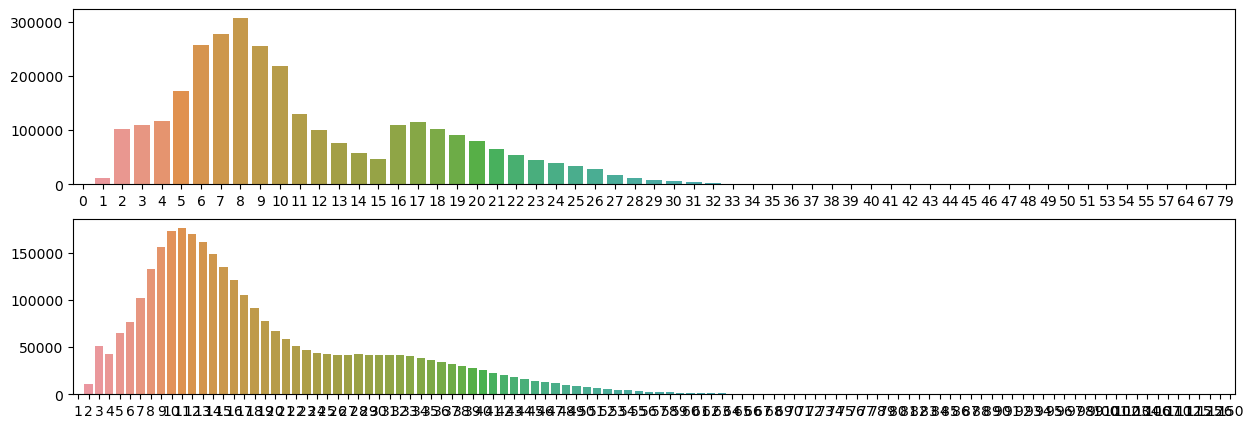

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(15,5))
sns.barplot(x=ko_len_unique[0], y=ko_len_unique[1], ax=ax[0])
sns.barplot(x=en_len_unique[0], y=en_len_unique[1], ax=ax[1])

얼추 길이가 30이 넘어가면 비효율적인 것으로 보이는데, 누적합을 기준으로 최대한 데이터를 살리면서 불필요하게 긴 문장을 잘라보겠습니다.

In [15]:
sents_total = 3052120

ko_len_cumsum = np.cumsum(ko_len_unique[1]/sents_total) # 각 문장길이별 누적합을 구합니다.
ko_len_threshold = np.argmax(np.where(ko_len_cumsum <= 0.95)) # 95%를 만족하는 구간을 찾습니다.

ko_threshold_passed_idx =  np.where(sents_ko_len <= ko_len_threshold)[0] # 만족하는 구간의 인덱스를 구합니다.

len(ko_threshold_passed_idx)

2856336

In [16]:
sents_ko_in = np.array(sents_ko_in) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.
sents_ko_in = sents_ko_in[ko_threshold_passed_idx]
sents_ko_in = list(sents_ko_in) # 작업이 끝났으니 다시 list로 변환합니다.
len(sents_ko_in)

/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/1113209805.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_ko_in = np.array(sents_ko_in) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.


2856336

In [17]:
# 한영 병렬구조가 맞아야 하므로, 영어문장에도 동일하게 인덱스를 적용합니다.
sents_en_in = np.array(sents_en_in)
sents_en_out = np.array(sents_en_out)

sents_en_in = sents_en_in[ko_threshold_passed_idx]
sents_en_out = sents_en_out[ko_threshold_passed_idx]

sents_en_in = list(sents_en_in)
sents_en_out = list(sents_en_out)


len(sents_en_in), len(sents_en_out)

/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/541671876.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_en_in = np.array(sents_en_in)
/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/541671876.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_en_out = np.array(sents_en_out)


(2856336, 2856336)

In [18]:
# 이번에는 영어 문장을 기준으로 진행합니다.
# 위에서 한국어 문장 기준으로 영어 문장도 같이 걸러냈으므로, 필요한 변수를 다시 선언합니다.
sents_en_len = np.array(list(map((lambda x: len(x)), sents_en_in)))
en_len_unique = np.unique(sents_en_len, return_counts=True)

sents_total = 2856336

en_len_cumsum = np.cumsum(en_len_unique[1]/sents_total) # 각 문장길이별 누적합을 구합니다.
en_len_threshold = np.argmax(np.where(en_len_cumsum <= 0.90)) # 95%를 만족하는 구간이 35인데, 부담스러워서 90% 구간(30)으로 줄였습니다.
en_len_threshold
en_threshold_passed_idx =  np.where(sents_en_len <= en_len_threshold)[0] # 만족하는 구간의 인덱스를 구합니다.

sents_en_in = np.array(sents_en_in) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.
sents_en_in = sents_en_in[en_threshold_passed_idx]
sents_en_in = list(sents_en_in) # 작업이 끝났으니 다시 list로 변환합니다.

# sents_en_out도 맞춰줍니다.

sents_en_out = np.array(sents_en_out) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.
sents_en_out = sents_en_out[en_threshold_passed_idx]
sents_en_out = list(sents_en_out) # 작업이 끝났으니 다시 list로 변환합니다.

len(sents_en_in), len(sents_en_out)

/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/2040034956.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_en_in = np.array(sents_en_in) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.
/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/2040034956.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_en_out = np.array(sents_en_out) # 위 조건들을 만족하는 문장들만 선별합니다. 계산을 위해 array로 강제변환합니다.


(2508564, 2508564)

In [19]:
# 이번에는 한국어 문장도 동일하게 맞춰줍니다.
sents_ko_in = np.array(sents_ko_in)
sents_ko_in = sents_ko_in[en_threshold_passed_idx]
sents_ko_in = list(sents_en_in)

len(sents_en_in)

/var/folders/tl/kj8jl_l95tb_v601gjk8cy8w0000gn/T/ipykernel_69767/2763378661.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sents_ko_in = np.array(sents_ko_in)


2508564

In [ ]:
# 데이터 백업
f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/Full/sents_ko_in.pkl', 'wb')
pickle.dump(sents_ko_in, f)
f.close()

f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/Full/sents_en_in.pkl', 'wb')
pickle.dump(sents_en_in, f)
f.close()

f = open('/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/Full/sents_en_out.pkl', 'wb')
pickle.dump(sents_en_out, f)
f.close()

## Configuration

### Hyper Parameter

In [21]:
# data amount
NUM_SAMPLES = 3000000
VAL_RATIO = 0.005

# Preprocess
ENC_TOKENIZER_LIMIT = None
DEC_TOKENIZER_LIMIT = None
ENC_PAD_MAXLEN = 20
DEC_PAD_MAXLEN = 30

# Vector Dimension
HIDDEN_DIM = 512
EMBEDDING_DIM = 512

# Compile, Fit
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 3

## Extra Options
REVERSE = True

### Path

In [22]:
# Load Preprocessed Data
MY_DRIVE_PRE_DIR = '/content/drive/MyDrive/Colab Notebooks/AI 부트캠프 Projects/NMT_Attention(논문구현)/preprocessed data/'
LOCAL_PRE_DIR = '/Users/GitHub/Projects/AI_Project/03_논문구현/preprocessed data/'
REMOTE_PRE_DIR = 'preprocessed'
SHARE_DRIVE_PRE_DIR = '/content/drive/MyDrive/preprocessed data/'

# Checkpoints

MY_DRIVE_CHK_DIR = '/content/drive/MyDrive/checkpoint/Attention/'
LOCAL_CHK_DIR = '/Users/GitHub/Projects/AI_Project/03_논문구현/checkpoint/Attention/'
REMOTE_CHK_DIR = ''
SHARE_DRIVE_CHK_DIR = '/content/drive/MyDrive/Colab Notebooks/최종모델/'

PRE_DIR = LOCAL_PRE_DIR
CHK_DIR = ''
CHK_NAME = f'Att_1Layer_NUM_SAMPLES_{str(NUM_SAMPLES)[:-4]}만.h5'

print(f'체크포인트 저장 경로: {CHK_DIR}')
print(f'체크포인트 파일명: {CHK_NAME}')

체크포인트 저장 경로: 
체크포인트 파일명: Att_1Layer_NUM_SAMPLES_300만.h5


### 데이터 전처리

## 데이터 불러오기


In [23]:
with open(f'{PRE_DIR}{NUM_SAMPLES}/ko_corpus.pkl', 'rb') as f:
    ko_corpus = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}{NUM_SAMPLES}/en_corpus.pkl', 'rb') as f:
    en_corpus = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}{NUM_SAMPLES}/sents_ko_in.pkl', 'rb') as f:
    sents_ko_in = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}{NUM_SAMPLES}/sents_en_in.pkl', 'rb') as f:
    sents_en_in = pickle.load(f)
    f.close()

with open(f'{PRE_DIR}{NUM_SAMPLES}/sents_en_out.pkl', 'rb') as f:
    sents_en_out = pickle.load(f)
    f.close()

# ko_corpus, en_corpus 리스트로 변환
ko_corpus = ko_corpus[:1000000]
en_corpus = en_corpus[:1000000]
sents_ko_in = sents_ko_in[:1000000]
sents_en_in = sents_en_in[:1000000]
sents_en_out = sents_en_out[:1000000]



# 결과 확인(데이터 수 확인)
print('-- 결과 확인(데이터 수 확인) --')
print(f'설정 데이터 수: {NUM_SAMPLES}')
print(len(sents_ko_in), len(sents_en_in), len(sents_en_out))

# 결과 확인(3개씩 문장 확인)
print()
print('-- 결과 확인(3개씩 문장 확인) --')
print(f'인코더의 입력 :\n,{sents_ko_in[-3:]}\n')
print(f'디코더의 입력 :\n,{sents_en_in[-3:]}\n')
print(f'디코더의 레이블 :\n,{sents_en_out[-3:]}\n')

-- 결과 확인(데이터 수 확인) --
설정 데이터 수: 3000000
1000000 1000000 1000000

-- 결과 확인(3개씩 문장 확인) --
인코더의 입력 :
,[['<sos>', 'Mo', 'Mo', 'Mo', '.'], ['<sos>', 'Koreans', 'who', 'eat', 'spicy', 'food', 'well', 'are', 'also', 'spicy', 'but', 'I', 'think', 'it', 'will', 'be', 'okay', 'to', 'eat', 'it', 'with', 'milk', '.'], ['<sos>', 'Four', 'large', 'holes', 'provide', 'good', 'ventilation', '.']]

디코더의 입력 :
,[['<sos>', 'Mo', 'Mo', 'Mo', '.'], ['<sos>', 'Koreans', 'who', 'eat', 'spicy', 'food', 'well', 'are', 'also', 'spicy', 'but', 'I', 'think', 'it', 'will', 'be', 'okay', 'to', 'eat', 'it', 'with', 'milk', '.'], ['<sos>', 'Four', 'large', 'holes', 'provide', 'good', 'ventilation', '.']]

디코더의 레이블 :
,[['Mo', 'Mo', 'Mo', '.', '<eos>'], ['Koreans', 'who', 'eat', 'spicy', 'food', 'well', 'are', 'also', 'spicy', 'but', 'I', 'think', 'it', 'will', 'be', 'okay', 'to', 'eat', 'it', 'with', 'milk', '.', '<eos>'], ['Four', 'large', 'holes', 'provide', 'good', 'ventilation', '.', '<eos>']]



In [24]:
sents_ko_in = list(map((lambda x: x[1:]), sents_ko_in))

In [25]:
sents_ko_in[-3]

['Mo', 'Mo', 'Mo', '.']

### 데이터 탐색

In [26]:
sents_ko_in_len = np.array(list(map((lambda x: len(x)), sents_ko_in)))
sents_en_in_len = np.array(list(map((lambda x: len(x)), sents_en_in)))

ko_len = np.unique(sents_ko_in_len, return_counts=True)
en_len = np.unique(sents_en_in_len, return_counts=True)

<Axes: >

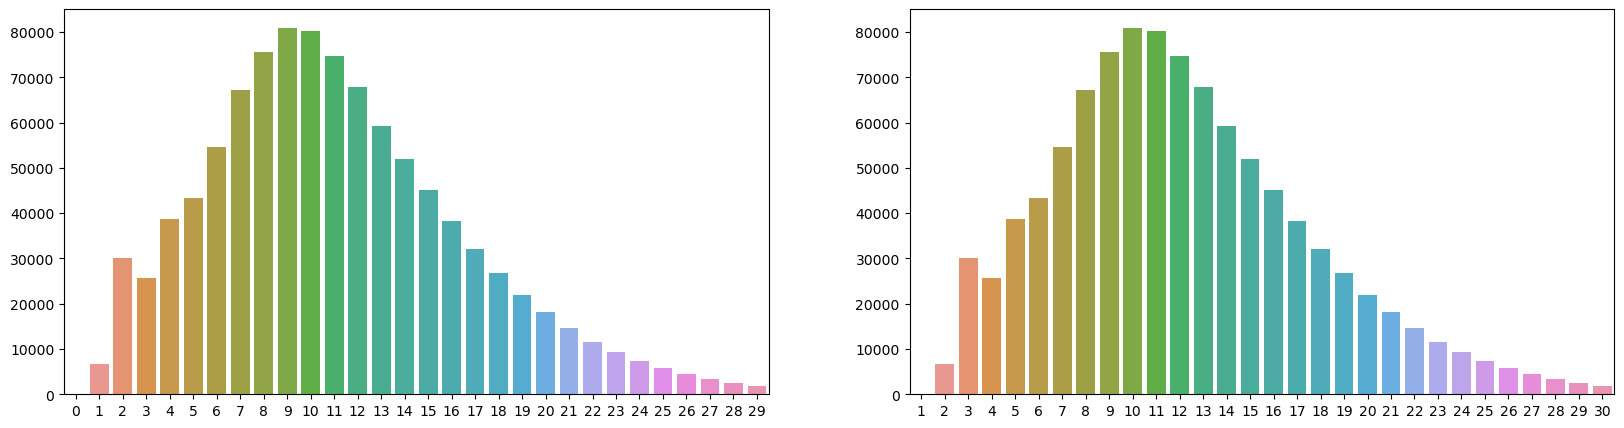

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.barplot(x=ko_len[0], y=ko_len[1], ax=ax[0])
sns.barplot(x=en_len[0], y=en_len[1], ax=ax[1])

## 데이터 전처리

### 단어집합(라벨링)

#### 한국어, 인코딩 데이터

In [28]:
# 한국어 단어집합
tokenizer_enc = Tokenizer(ENC_TOKENIZER_LIMIT, filters='', lower=False, oov_token='<UNK>')
tokenizer_enc.fit_on_texts(sents_ko_in)

# 인코더 데이터
encoder_input = tokenizer_enc.texts_to_sequences(sents_ko_in)


# 영어 단어집합
tokenizer_dec = Tokenizer(DEC_TOKENIZER_LIMIT, filters='', lower=False, oov_token='<UNK>')
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 데이터
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)


# 결과 확인
print(f'encoder_input: \n{encoder_input[-3:]}\n')
print(f'decoder_input: \n{decoder_input[-3:]}\n')
print(f'decoder_target: \n{decoder_target[-3:]}\n')

encoder_input: 
[[7468, 7468, 7468, 2], [1765, 100, 224, 891, 178, 113, 18, 57, 891, 54, 4, 61, 11, 25, 21, 311, 5, 224, 11, 19, 1299, 2], [3724, 371, 3973, 269, 64, 3424, 2]]

decoder_input: 
[[3, 7470, 7470, 7470, 2], [3, 1767, 102, 226, 893, 180, 115, 20, 59, 893, 56, 6, 63, 13, 27, 23, 313, 7, 226, 13, 21, 1301, 2], [3, 3726, 373, 3975, 271, 66, 3426, 2]]

decoder_target: 
[[7470, 7470, 7470, 2, 4], [1767, 102, 226, 893, 180, 115, 20, 59, 893, 56, 6, 63, 13, 27, 23, 313, 7, 226, 13, 21, 1301, 2, 4], [3726, 373, 3975, 271, 66, 3426, 2, 4]]



In [29]:
# 단어집합 크기 저장
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

# 단어:라벨, 라벨:단어 딕셔너리 저장
src2idx = tokenizer_enc.word_index
idx2src = tokenizer_enc.index_word
tar2idx = tokenizer_dec.word_index
idx2tar = tokenizer_dec.index_word

# 단어집합 크기 확인
print(f'한국어 단어집합 크기: {SRC_VOCAB_SIZE}')
print(f'영어 단어집합 크기: {TAR_VOCAB_SIZE}')

# # 딕셔너리 확인
# print(src2idx)
# print(idx2src)
# print(tar2idx)
# print(idx2tar)

# 패딩했을 때의 토큰 <PAD> 추가
idx2src[0] = '<PAD>'
idx2tar[0] = '<PAD>'

한국어 단어집합 크기: 70955
영어 단어집합 크기: 70957


### 패딩

In [30]:
# 각 데이터의 최대길이만큼 패딩(padding) 수행
if REVERSE:
    encoder_input = pad_sequences(sequences=encoder_input, maxlen=ENC_PAD_MAXLEN, padding='post')
else:
    encoder_input = pad_sequences(sequences=encoder_input, maxlen=ENC_PAD_MAXLEN, padding='pre')

decoder_input = pad_sequences(sequences=decoder_input, maxlen=DEC_PAD_MAXLEN, padding='post')
decoder_target = pad_sequences(sequences=decoder_target, maxlen=DEC_PAD_MAXLEN,  padding='post')

if REVERSE:
    encoder_input = encoder_input[:,::-1]


# 결과 확인
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

# 각 데이터의 최대길이 저장
print(encoder_input.shape)
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

인코더의 입력의 크기(shape) : (1000000, 20)
디코더의 입력의 크기(shape) : (1000000, 30)
디코더의 레이블의 크기(shape) : (1000000, 30)
(1000000, 20)


In [31]:
print(f'encoder input sample: \n{encoder_input[0]}\n')
print(f'decoder input sample: \n{decoder_input[0]}\n')
print(f'decoder target sample: \n{decoder_target[0]}\n')

encoder input sample: 
[    0     0     0     2  8869     3    12  2574   820   382     5     6
   827    16   716  6167     7     9 29793  8869]

decoder input sample: 
[    3  8871 29795    11     9  6169   718    18   829     8     7   384
   822  2576    14     5  8871     2     0     0     0     0     0     0
     0     0     0     0     0     0]

decoder target sample: 
[ 8871 29795    11     9  6169   718    18   829     8     7   384   822
  2576    14     5  8871     2     4     0     0     0     0     0     0
     0     0     0     0     0     0]



### 학습 데이터, 테스트 데이터 분리

In [32]:
# 데이터 섞기

## 랜덤 인덱스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(f'랜덤 시퀀스(인덱스): {indices}')

## 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print()
print(f'encoder_input: \n{encoder_input[indices[0]]}\n')
print(f'decoder_input: \n{decoder_input[indices[1]]}\n')
print(f'decoder_target: \n{decoder_target[indices[1]]}\n')

랜덤 시퀀스(인덱스): [661112 682215  85983 ... 538309  48812 590365]

encoder_input: 
[   0    0    0    2 1051 4654   21   25  787  977  794   78 1920    9
  961 1479    3   68  814  101]

decoder_input: 
[   3  272   12   62    6   60   35    7  211    5 6833   10 2480   13
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

decoder_target: 
[ 272   12   62    6   60   35    7  211    5 6833   10 2480   13    2
    4    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]



In [33]:
# 데이터 분리
n_of_val = int(NUM_SAMPLES * VAL_RATIO)

# train_data
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test_data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


# 결과 확인
print("train data's shape")
print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)
print("\ntest data's shape")
print(encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape)

train data's shape
(985000, 20) (985000, 30) (985000, 30)

test data's shape
(15000, 20) (15000, 30) (15000, 30)


## 모델링

### 인코더(Train)

In [36]:
# 인코더(Train)


## layer
### Input
enc_inputs = Input(shape=(MAX_ENC_LEN, ), name='ENC_Input')
### Embedding
enc_embedding_layer = Embedding(input_dim=SRC_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length= MAX_ENC_LEN,
                                mask_zero=True, name='ENC_Embedding')
### Normalization
enc_normalize_layer = Normalization(invert=False, name='ENC_Normalization')
### LSTM
enc_lstm1 = LSTM(units=HIDDEN_DIM,
                 dropout=0.2, # dropouts
                 return_state=True, return_sequences=True, name='ENC_LSTM-1')

## input -> output
### Input -> Embedding
enc_emb = enc_embedding_layer(enc_inputs)
### Normalizing
enc_normalized = enc_normalize_layer(enc_emb)
### Embedding -> LSTM -> LSTM/Output
enc_lstm1_sequences, enc_h1_state, enc_c1_state = enc_lstm1(enc_emb)

## 데이터 저장
enc_states_1 = [enc_h1_state, enc_c1_state]

### 디코더(Train)

In [37]:
# 디코더(Train)

## layer
### Input
dec_inputs = Input(shape=(MAX_DEC_LEN, ), name='DEC_Input')
### Embedding
dec_embedding_layer = Embedding(input_dim=TAR_VOCAB_SIZE, output_dim=HIDDEN_DIM, input_length= MAX_DEC_LEN, mask_zero=True, name='DEC_Embedding')
### Normalization
dec_normalize_layer = Normalization(invert=False, name='DEC_Normalization')
### LSTM
dec_lstm1 = LSTM(units=HIDDEN_DIM, return_state=True, return_sequences=True,
                 dropout=0.2, # dropouts
                 name='DEC_LSTM-1')
# Attention
dec_attention_layer = Attention(score_mode='dot', name='DEC_Attention')
dec_concat_layer = Concatenate(name='DEC_Concat')
### Dense
dec_dense_tanh = Dense(units=HIDDEN_DIM, activation='tanh', name='DEC_Dense-tanh')
dec_dense_softmax = Dense(units=TAR_VOCAB_SIZE, activation='softmax', name='DEC_Dense-softmax')

## input -> output
### Input -> Embedding
dec_emb = dec_embedding_layer(dec_inputs)
### Embedding -> LSTM -> LSTM
dec_lstm1_sequences, dec_h1_state, dec_c1_state = dec_lstm1(dec_emb, initial_state=enc_states_1)
### Normalizing
dec_normalized = dec_normalize_layer(dec_emb)
### Attention, Concatenate
dec_att_context_vec = dec_attention_layer([dec_lstm1_sequences, enc_lstm1_sequences], training=True)
dec_concatted = dec_concat_layer([dec_att_context_vec, dec_lstm1_sequences])
### Dense
dec_h_tilda = dec_dense_tanh(dec_concatted)
dec_y_hat = dec_dense_softmax(dec_h_tilda)

### 컴파일 및 summary

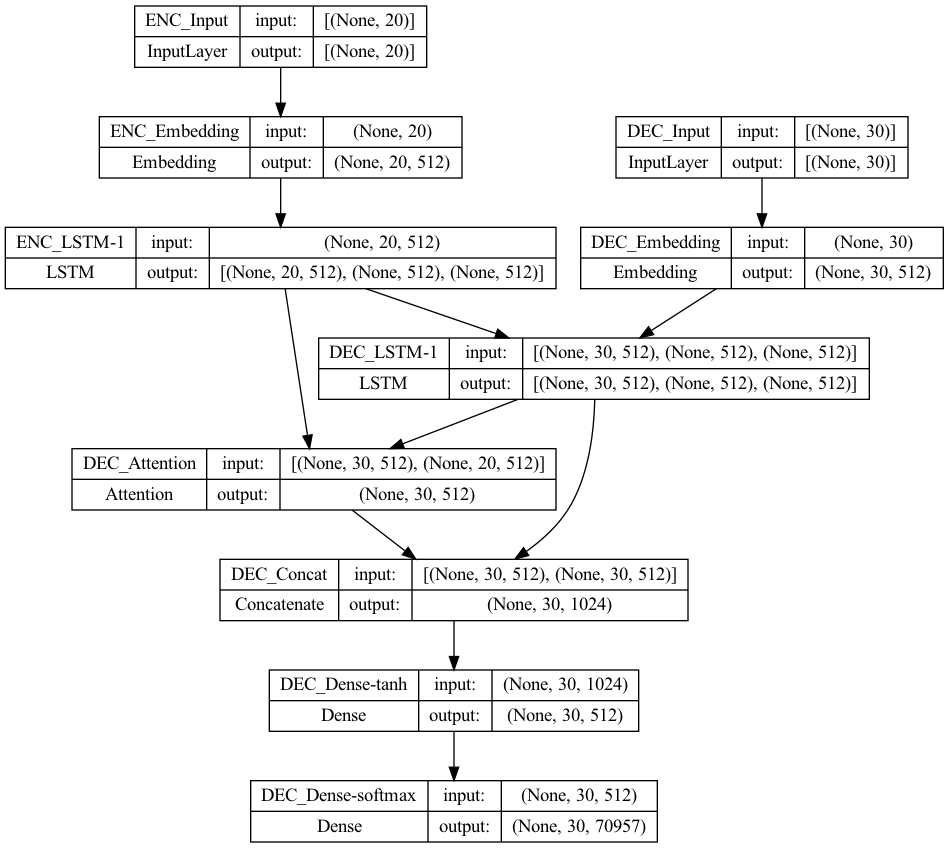

In [38]:
# 모델 입출력 정의
model = Model(inputs=[enc_inputs, dec_inputs], outputs=dec_y_hat)

# compile
model.compile(
    optimizer = Adam(learning_rate=LEARNING_RATE),
    loss = 'sparse_categorical_crossentropy',
    metrics = 'sparse_categorical_accuracy'
)

# summary
# model.summary()

# plot
plot_model(model, show_shapes=True)

### 학습

In [84]:
# 콜백함수
es = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
chk = ModelCheckpoint(filepath=CHK_DIR + CHK_NAME,
                      monitor='val_loss',
                      save_best_only=True,
                      mode='min',
                      verbose=0
                      )



# @desktop_sender(title='Attention 1-layer')
def action():
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                        validation_data=[[encoder_input_test, decoder_input_test], decoder_target_test],
                        batch_size=BATCH_SIZE,
                        callbacks=[es, chk],
                        epochs=EPOCHS,
                        verbose=1)

    return history

history = action()

Epoch 1/3
30782/30782 [==============================] - 2465s 80ms/step - loss: 0.9039 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.9581
Epoch 2/3
30782/30782 [==============================] - 2464s 80ms/step - loss: 0.2742 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.2608 - val_sparse_categorical_accuracy: 0.9674
Epoch 3/3
  103/30782 [..............................] - ETA: 40:21 - loss: 0.2230 - sparse_categorical_accuracy: 0.9700

KeyboardInterrupt: ignored

## 중간 결과 확인(시각화)

In [85]:
model.save('Attention_1Layer_100만.h5')

### 시각화

In [40]:
# 체크포인트 불러오기
# model.load_weights(CHK_DIR + CHK_NAME)
model.load_weights('Attention_1Layer_100만.h5')

In [ ]:
# visualize
def visualizer(history=history, metrics='sparse_categorical_accuracy'):

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Loss", "SC Accuracy"))

    # train loss
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['loss'],
                             mode='lines+markers',
                             name='Train Loss'
                             ),
                  row=1, col=1)

    # test loss
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_loss'],
                             mode='lines+markers',
                             name='Val Loss'
                             ),
                  row=1, col=1)

    # train score
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['sparse_categorical_accuracy'],
                             mode='lines+markers',
                             name='Train SCA'
                             ),
                  row=1, col=2)

    # test score
    fig.add_trace(go.Scatter(x=history.epoch,
                             y=history.history['val_sparse_categorical_accuracy'],
                             mode='lines+markers',
                             name='Val SCA'
                             ),
                  row=1, col=2)

    fig.update_layout(showlegend=True)
    fig.show()

visualizer(history)

## Inference

### 모델링

#### 인코더

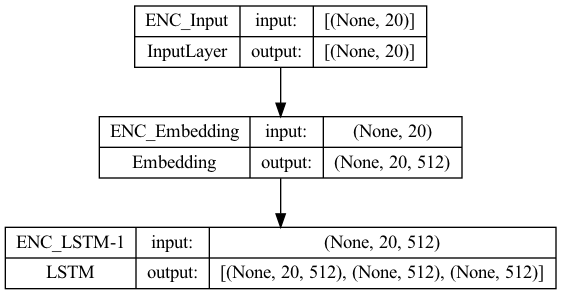

In [53]:
# 인코더
enc_model = Model(inputs=enc_inputs, outputs=[enc_lstm1_sequences, enc_states_1])

# 시각화
plot_model(enc_model, show_shapes=True)

#### 디코더(Predict)

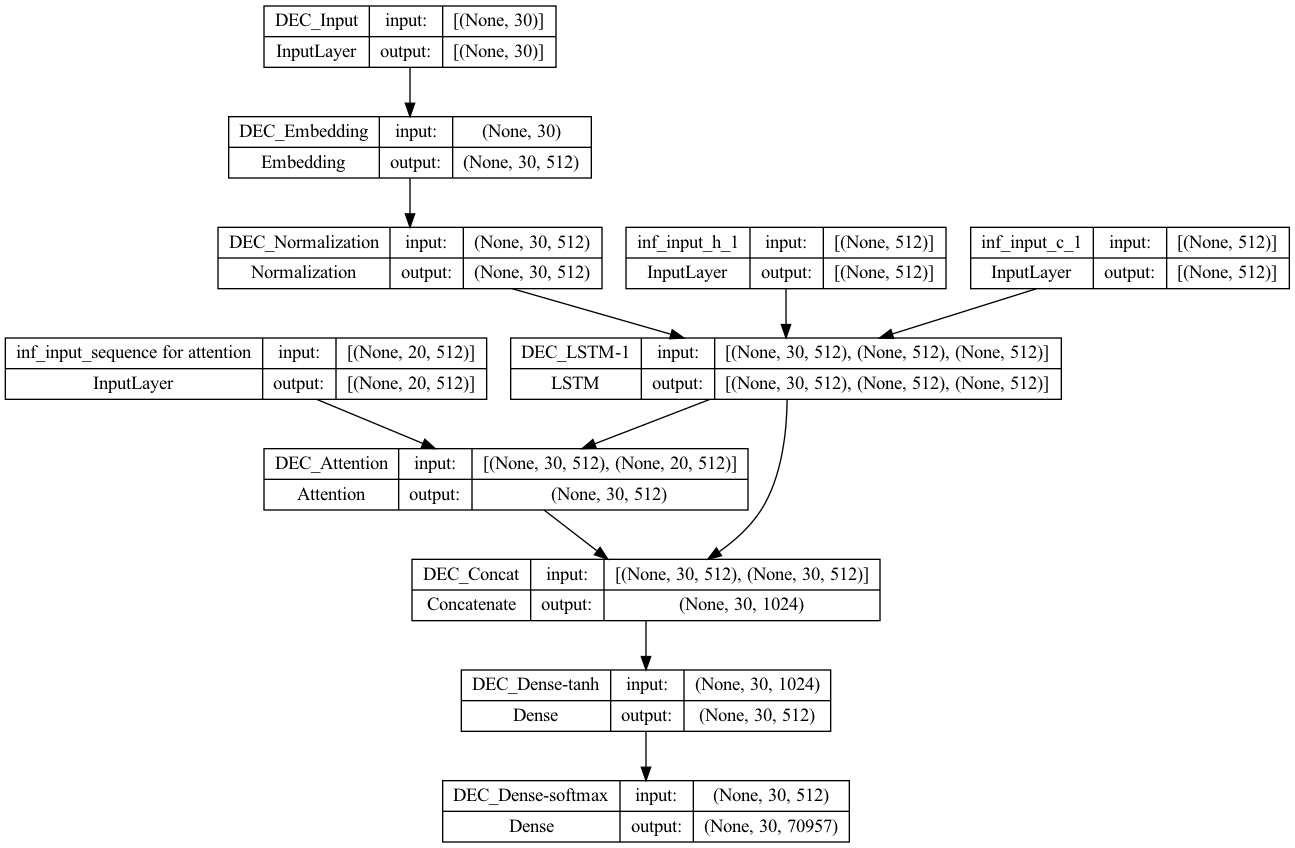

In [54]:
# 디코더 (Inference, inf: 위의 디코더 섹션과의 혼동을 막기 위해 inf로 명명.)
## layer
### Input: 이전 시점의 상태를 보관할 텐서
inf_input_sequences = Input(shape=(MAX_ENC_LEN, HIDDEN_DIM), name='inf_input_sequence for attention')

inf_input_h_1 = Input(shape=(HIDDEN_DIM,), name='inf_input_h_1')
inf_input_c_1 = Input(shape=(HIDDEN_DIM,), name='inf_input_c_1')

inf_states_inputs_1 = [inf_input_h_1, inf_input_c_1]

## Input -> Output
### Input -> dec_Embedding: 훈련 때 사용했던 임베딩 층 재활용
inf_emb = dec_embedding_layer(dec_inputs)
### Normalizing
inf_normalized = dec_normalize_layer(inf_emb)
### Embedding -> LSTM -> LSTM:  다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
inf_lstm1_sequences, inf_state_h_1, inf_state_c_1 = dec_lstm1(inf_normalized, initial_state=inf_states_inputs_1)

inf_lstm1_states = [inf_state_h_1, inf_state_c_1]
# Attention
inf_att_context_vec = dec_attention_layer([inf_lstm1_sequences, inf_input_sequences], training=False)
inf_concatted = dec_concat_layer([inf_att_context_vec, inf_lstm1_sequences])
inf_h_tilda = dec_dense_tanh(inf_concatted)
inf_y_hat = dec_dense_softmax(inf_h_tilda)

### 다음 단어 예측 시 디코더의 initial_state로 들어감

## 모든 시점에 대해서 단어 예측(Fully Connected)

## 수정된 디코더
dec_model = Model(inputs=[dec_inputs] + [inf_input_sequences, inf_states_inputs_1],
                  outputs= [inf_y_hat] + [inf_lstm1_sequences, inf_lstm1_states])

# 시각화
plot_model(dec_model, show_shapes=True)

### Decode Sequence

In [55]:
# 원문에서도 영어가 껴있고, 어차피 조사만 따로 버릴 것도 아니기에 한국어, 영어 동일하게 전처리 하겠습니다.
def preprocess_sentence(sent):
    sent = re.sub(r"([?.!,¿])", r" \1", sent) # 구두점 앞 공백 추가
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent) # 다수의 공백을 하나의 공백으로 치환

    return sent


# 학습 데이터, 타겟 데이터 생성 함수
def load_preprocessed_data(ko_corpus, en_corpus, debug=False):
    encoder_input, decoder_input, decoder_target = [], [], []
    # encoder_input: encoder layer에 들어갈 학습 데이터
    # decoder_input: decoder layer에 들어갈 학습 데이터(teacher forcing용)
    # decoder_target: decoder layer에서 나온 결과랑 비교할 타겟 데이터

    for i, (src_line, tar_line) in enumerate(zip(ko_corpus, en_corpus)):

        # source 데이터 (scr_lin) 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 (tar_line) 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()] # target for teacher forcing
        tar_line_out = [w for w in (tar_line + " <eos>").split()] # final target

        # reverse
        # src_line.reverse()

        # append
        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # sos + 클리닝
        decoder_target.append(tar_line_out) # 클리닝 + eos

        if i == NUM_SAMPLES - 1:
            break


        # debugging section
        if debug:
            print(f'(debug) 첫 번째 문장 작업 결과')
            print(f'src_line: \n{src_line}\n')
            print(f'tar_line_in: \n{tar_line_in}\n')
            print(f'tar_line_out: \n{tar_line_out}\n')
            break

    return encoder_input, decoder_input, decoder_target

In [56]:
def translate(sentence):
    # 전처리

    #   전처리 함수
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # reverse
    if REVERSE:
        tokens.reverse()

    #   라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    #   패딩
    enc_input = pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='pre')
    inf_enc_state_sequences, inf_enc_state_value_1 = enc_model.predict(enc_input)

    #   Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1)) # 패딩 후 array로 반환되기 때문에 마찬가지로 array로 맞춰준다.
    target_seq[0, 0] = tar2idx['<sos>']


    # Prediction 시작
        # stop_condition이 True가 될 때까지 루프 반복
        # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.

    stop_condition=False
    dec_sentence=''

    for i in range(MAX_DEC_LEN):

        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, previous_lstm1_sequences, previous_lstm1_states = dec_model.predict(x=[target_seq] + [inf_enc_state_sequences, inf_enc_state_value_1], verbose=0)

        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]
        # 현재 시점의 예측 단어를 예측 문장에 추가
        dec_sentence += ' ' + result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0,0] = result_token_index

        # 현재 시점의 상태 -> 다음 시점의 상태로 업데이트
        inf_enc_state_sequences, inf_enc_state_value_1  = previous_lstm1_sequences, previous_lstm1_states

        # Stop condition <eos>에 도달하면 중단
        if result_word == '<eos>':
            break

    return dec_sentence.strip(' <eos>')

## 결과 확인

In [57]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:]

# 아무 문장이나 선택
n_samples = 5
np.random.choice(train_idx, n_samples)

array([122488,  28804, 181750, 704251, 313958])

In [58]:
# train data - translate

n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = ko_corpus[idx]
    answer_sentence = en_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 2s 2s/step


2023-06-20 10:01:26.435997: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-06-20 10:01:26.763768: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


입력문장 : 내가 저녁 음식 만들어 줄게요.
정답문장 : I'll make some food for dinner.
번역문장 : Showcasing electric electric purchased share hell
--------------------------------------------------
1/1 [==============================] - 0s 63ms/step
입력문장 : 좋아요, 그리고 한 묶음의 연비는 얼마입니까?
정답문장 : Ok, and how much does a bundle coast?
번역문장 : Showcasing electric electric purchased curating per task
--------------------------------------------------
1/1 [==============================] - 0s 65ms/step
입력문장 : 좋아요, 그럼 의논할 문제가 있나요?
정답문장 : Okay, so do you have any issue to discuss?
번역문장 : Showcasing electric electric purchased share hell
--------------------------------------------------
1/1 [==============================] - 0s 62ms/step
입력문장 : 완벽하군요, 가격은 어떻게 되나요?
정답문장 : Perfect, how much is it being sold?
번역문장 : Showcasing electric pressure giving ?
--------------------------------------------------
1/1 [==============================] - 0s 65ms/step
입력문장 : 그것이 바로 우리가 회사와 제품에 대한 광고 서비스를 제공하는 이유입니다.
정답문장 : that's why we offer

In [59]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = ko_corpus[idx]
    answer_sentence = en_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 69ms/step
입력문장 : 내 생산 시간에 영향을 미칩니다.
정답문장 : It will impact my production time.
번역문장 : Showcasing electric electric purchased share hell
--------------------------------------------------
1/1 [==============================] - 0s 63ms/step
입력문장 : 호버링이란 드론의 높이와 위치를 자동으로 설정하는 것을 의미합니다.
정답문장 : Hovering means an automatic setting of the height and the location of the drone.
번역문장 : Showcasing reconstructs pay inform ushers salsa training per bad
--------------------------------------------------
1/1 [==============================] - 0s 58ms/step
입력문장 : 지난번에 보내주신 카탈로그는 잘 확인해보았습니다.
정답문장 : I checked the catalog you sent me last time.
번역문장 : Showcasing electric electric purchased share hell
--------------------------------------------------
1/1 [==============================] - 0s 60ms/step
입력문장 : >광수야.
정답문장 : Gwang-su.
번역문장 : Logical providing off
--------------------------------------------------
1/1 [==============================] - 0s 84ms/step
입력문

```
1/1 [==============================] - 0s 27ms/step
입력문장 : 그것은 한 시간도 채 되지 않아 찢어 졌습니다.
정답문장 : It got ripped within an hour.
번역문장 : rganizations publicity aged aged aged aged aged aged e shaft e e tuning migration Affordable minutes degraded minutes stroller minutes rained minutes Results info DNA Chanyeol harmonic downtown lowest Working
--------------------------------------------------
1/1 [==============================] - 0s 27ms/step
입력문장 : 그 기회를 얻고 저는 저녁에 보충수업을 나가면 다시 학교에 다녔습니다.
정답문장 : With that opportunity, I went back to school and took evening classes.
번역문장 : publicity publicity publicity publicity publicity publicity publicity publicity splash splash rappers coordinator e Perforated e prehistory e SONG organizing whereas humid humid Trudeau Savoiardi Philiphine Namsadangpae MIP veins wingardium blurry
--------------------------------------------------
1/1 [==============================] - 0s 25ms/step
입력문장 : 외환은행 인천국제공항 지점은 1년 내내 새벽 6시부터 저녁 9시까지 운영되고 있어요.
정답문장 : Incheon Airport branch of Korea Exchage Bank is open from 6 am to 9 pm all year round.
번역문장 : publicity publicity publicity publicity publicity publicity publicity communicates splash splash coordinator coordinator coordinator deposit deposit cart Yong silken junction junction Ma Ma Baird assets immigrated irreplaceable nipped Ma attract Kindly
--------------------------------------------------
1/1 [==============================] - 0s 26ms/step
입력문장 : 그녀의 긴 회의가 끝났습니다.
정답문장 : Her long meeting is over.
번역문장 : discover discover stI stI Makguksu scooters Technip Technip Technip massage youve waiters waiters malady vary mini mini Saga photogenic reins Fold Fold videotape northeasterly Vajaya Vajaya Hit invisible Browser Browser
--------------------------------------------------
1/1 [==============================] - 0s 26ms/step
입력문장 : 거미줄에 있는 거미는 이상해 보였어요.
정답문장 : The spider in the spider's web looked strange.
번역문장 : ptimized revived revived am am am am am am CEOs CEOs suede suede suede Costco trembles spams spams spams nonsan sold Friends matrix Toms Sydney Yangming Autumn barking Advertisement Advertisement
--------------------------------------------------
```